In [1]:
import xarray as xr
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
opar_folder = sorted(Path('/homedata/noel/OPAR/LIO3T.daily/').glob('*.nc4'))
oparpath = opar_folder[50]
opar = xr.open_dataset(oparpath)


'km'

In [6]:
oparsimulpath = Path('/homedata/nmpnguyen/OPAR/Processed/LIO3T/2019-06-17_simul.pkl')
oparsimul = pd.read_pickle(oparsimulpath)

In [7]:
oparraw = opar.sel(channel='00532.p')#.isel(time=100)
oparraw2 = opar.sel(channel='00532.p')+opar.sel(channel='00532.s')
oparraw

<xarray.Dataset>
Dimensions:  (range: 16380, time: 177)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-17T15:09:33 ... 2019-06-17T21:06:15
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
    channel  <U7 '00532.p'
Data variables:
    signal   (time, range) float64 ...

In [8]:
   

def range_corrected_signal(signal_raw, opar_range, opar_alt, bck_correction = False):
    '''
    signal_raw = raw signal (MHz) without any correction
    opar_range = range in meters 
    opar_alt = altitude in meters
    '''
    if bck_correction == False:
        rcs = signal_raw * (opar_range**2) #MHz.m^2
    else:
        idx = ((opar_alt>=80000)&(opar_alt<=100000))
        signal_bck = signal_raw.isel(range=idx)
        bck = signal_bck.mean(("range"))
        rcs = (signal_raw - bck)*(opar_range**2)
    return rcs

rep1= range_corrected_signal(opar.sel(channel='00532.p'), opar['range'].values*1e3, opar['range'].values*1e3+2160, False)
print(rep1)
print('-----------')
rep2 = range_corrected_signal(opar.sel(channel='00532.p')+opar.sel(channel='00532.s'), opar['range'].values*1e3, opar['range'].values*1e3+2160, False)
print(rep2)

<xarray.Dataset>
Dimensions:  (range: 16380, time: 177)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-17T15:09:33 ... 2019-06-17T21:06:15
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
    channel  <U7 '00532.p'
Data variables:
    signal   (time, range) float64 0.0 4.2e+05 1.649e+06 ... 1.509e+10 0.0 0.0
-----------
<xarray.Dataset>
Dimensions:  (range: 16380, time: 177)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-17T15:09:33 ... 2019-06-17T21:06:15
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
Data variables:
    signal   (time, range) float64 0.0 7.617e+05 ... 3.018e+10 3.018e+10


/mnt/homedafs-2.5/lov/homedata/nmpnguyen/python_envs/ipral_tools/lib/python3.8/site-packages/xarray/core/computation.py:724: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


[Text(0.5, 1.0, 'OPAR: 532nm, Photocouting LIO3T \n2019-06-17.nc4')]

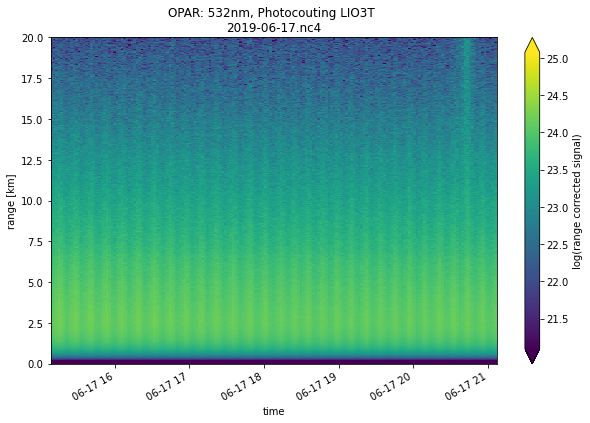

In [9]:
import datetime as dt
fig, ax=plt.subplots(figsize=[10,6])
np.log(rep2['signal']).plot(x='time',y ='range',ax=ax, cmap='viridis',cbar_kwargs={"label": "log(range corrected signal)"}, robust=True)
#ax.set_xlim(dt.datetime(2019,6,17,15), dt.datetime(2019,6,17,18))
ax.set_ylim(0,20)
ax.set(title='OPAR: 532nm, Photocouting LIO3T \n'+str(oparpath.name))

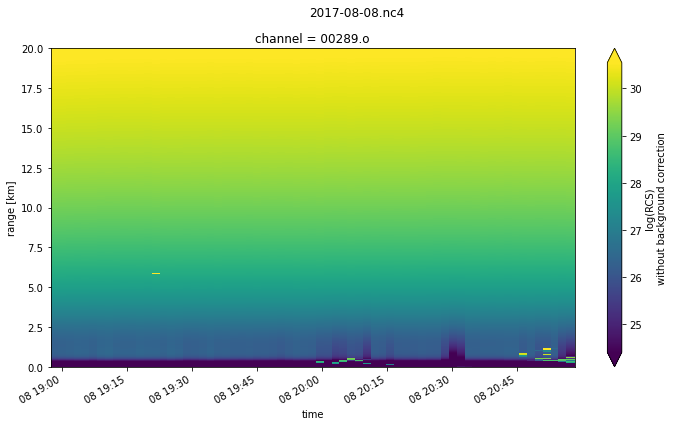

In [78]:
limiteZ = np.where(opar['range'][:]<20)[0]
fig, ax=plt.subplots(figsize=[10,6])
np.log(opar.isel(channel=0, range=limiteZ)['signal']*np.square(opar['range']*1e3)).plot(x='time',y ='range',ax=ax, cmap='viridis',
                                                                                        cbar_kwargs={"label": "log(RCS) \nwithout background correction"}, robust=True,
                                                                                       ylim=(0, 20))
fig.suptitle(oparpath.name)
plt.tight_layout()
plt.savefig(f'/homedata/nmpnguyen/OPAR/LI1200.daily.QL/QL-{opar["channel"][0].values}-{oparpath.name}.png')

In [10]:
pression = oparsimul['pression'].unstack(level=1)
ta = oparsimul['ta'].unstack(level=1)


In [326]:
#______AVERAGE:ALL to 1_________
oparrcsAV = rep1.resample(time='30Min').mean()
oparrcs1pf = oparrcsAV.isel(time=1)
print(oparrcs1pf)
print(rep1['signal'].isel(time=100))
#oparrcs1pf = oparrcs.isel(time=100).sel(channel='00532.p')

oparrcsAV2 = rep2.resample(time='3H').mean()
oparrcs1pf2 = oparrcsAV2.isel(time=1)

<xarray.Dataset>
Dimensions:  (range: 16380)
Coordinates:
    time     datetime64[ns] 2019-06-17T15:30:00
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
    channel  <U7 '00532.p'
Data variables:
    signal   (range) float64 0.0 4.135e+05 1.649e+06 ... 1.401e+10 1.078e+10
<xarray.DataArray 'signal' (range: 16380)>
array([0.00000000e+00, 4.08318750e+05, 1.59682500e+06, ...,
       1.50865948e+10, 3.01768744e+10, 1.50902798e+10])
Coordinates:
    time     datetime64[ns] 2019-06-17T18:32:13
  * range    (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8 122.8
    channel  <U7 '00532.p'


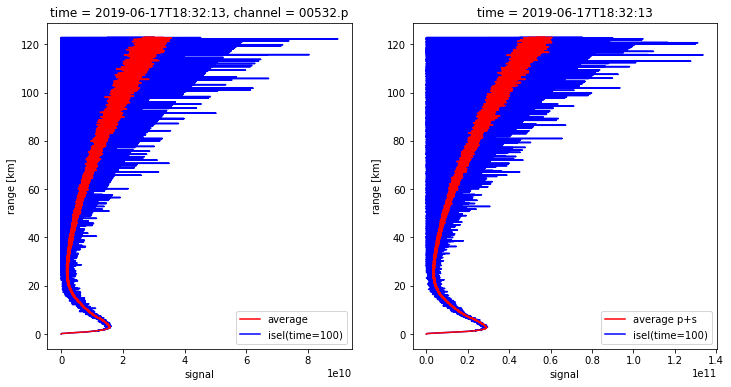

In [12]:
fig, (ax,ax2) = plt.subplots(ncols=2, nrows=1, figsize=[12,6])
(oparrcs1pf['signal'][:len(opalt)]).plot(y='range', ax=ax, color='r', zorder=10, label='average')
(rep1['signal'].isel(time=100)[:len(opalt)]).plot(y='range', ax=ax, color='b', label='isel(time=100)')
ax.legend()
(oparrcs1pf2['signal'][:len(opalt)]).plot(y='range', ax=ax2, color='r', zorder=10, label='average p+s')
(rep2['signal'].isel(time=100)[:len(opalt)]).plot(y='range', ax=ax2, color='b', label='isel(time=100)')
ax2.legend()

### Comment
Appliquer les méthodes 

In [13]:
import sys
sys.path.append('/home/nmpnguyen/')
from imp import reload as rl
import Attn_Bsc_theorie 
rl(Attn_Bsc_theorie)
from Attn_Bsc_theorie import Method1, Method2, Method3, Calibration

In [14]:
#______METHODE 1_________
opalt = opalt[:pression.shape[1]]
opbetamol1 = Method1.computeMolATB_Calipso(P=pression.iloc[100,:]*1e-2, T=ta.iloc[100,:])
attnbetamol1 = Method1.computeAttnMolATB_Calipso(scat_vol=opbetamol1[0].values.astype('float'), 
                                                 beta_vol=opbetamol1[1].values.astype('float'), 
                                                 alt=opalt, 
                                                 datafrom='bottom')

In [15]:
#______METHODE 2_________
nd2 = Method2.compute_numb_density(P=pression.iloc[100,:], T=ta.iloc[100,:])
opextinction2 = Method2.computeMolExtinction(P=pression.iloc[100,:]*1e-2, T=ta.iloc[100,:], ND=nd2)
opbetamol2 = Method2.computeMolBackscatter(opextinction2)
attnbetamol2 = Method2.computeAttnMolBackscatter(alt=opalt, datafrom='bottom', 
                                                 extinction=opextinction2.values.astype('float'), 
                                                 beta_vol=opbetamol2.values.astype('float'))

In [16]:
#______METHODE 3_________
opbetamol3 = Method3.computeMolBackscatter(P = pression.iloc[100,:], T= ta.iloc[100,:], w=532)
attnbetamol3 = Method3.computeAttnMolBackscatter(alt=opalt, datafrom='bottom', 
                                                 extinction=opbetamol3[0].values.astype('float'), 
                                                 beta_vol=opbetamol3[1].values.astype('float'))

In [17]:
#______TEST FOR LOOP IN ATTENUATION FUNCTION____________
print(opbetamol3[0].values.astype('float').max())
E=opbetamol1[0].values.astype('float')
B=opbetamol1[1].values.astype('float')
T = np.zeros_like(E)
for i in range(1, len(opalt)):
    T[i] = T[i-1]+ E[i]*(opalt[i] - opalt[i-1])

print(T)
print(np.exp(-2*T))

print('--------')
A = B*np.exp(-2*T)

print(A[100:110])
print(attnbetamol1[100:110])


1.0586500552035323e-05
[0.00000000e+00 7.80485990e-03 1.56030030e-02 ... 9.51100694e+00
 9.51167934e+00 9.51235109e+00]
[1.00000000e+00 9.84511480e-01 9.69275876e-01 ... 5.48080480e-09
 5.47343919e-09 5.46609058e-09]
--------
[2.46242456e-05 2.42544191e-05 2.38903913e-05 2.35320679e-05
 2.31793561e-05 2.28321646e-05 2.24904037e-05 2.21539852e-05
 2.18228224e-05 2.14968300e-05]
[2.46242456e-05 2.42544191e-05 2.38903913e-05 2.35320679e-05
 2.31793561e-05 2.28321646e-05 2.24904037e-05 2.21539852e-05
 2.18228224e-05 2.14968300e-05]


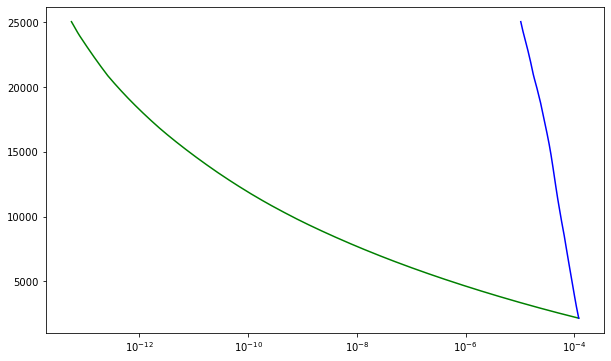

In [18]:
#______TEST FOR LOOP IN ATTENUATION FUNCTION____________
fig, ax = plt.subplots(figsize=[10,6])
#ax.plot(np.exp(-2*T), opalt, color='r')
ax.semilogx(attnbetamol1, opalt, color='g')
ax.semilogx(B, opalt, color='b')

## Etude Coef de Corrélation et Résidus

In [20]:
new = xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-06-11RF_v1.nc')
# xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-17RF_v3.nc')
# xr.open_dataset('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-17RF_v4.nc')

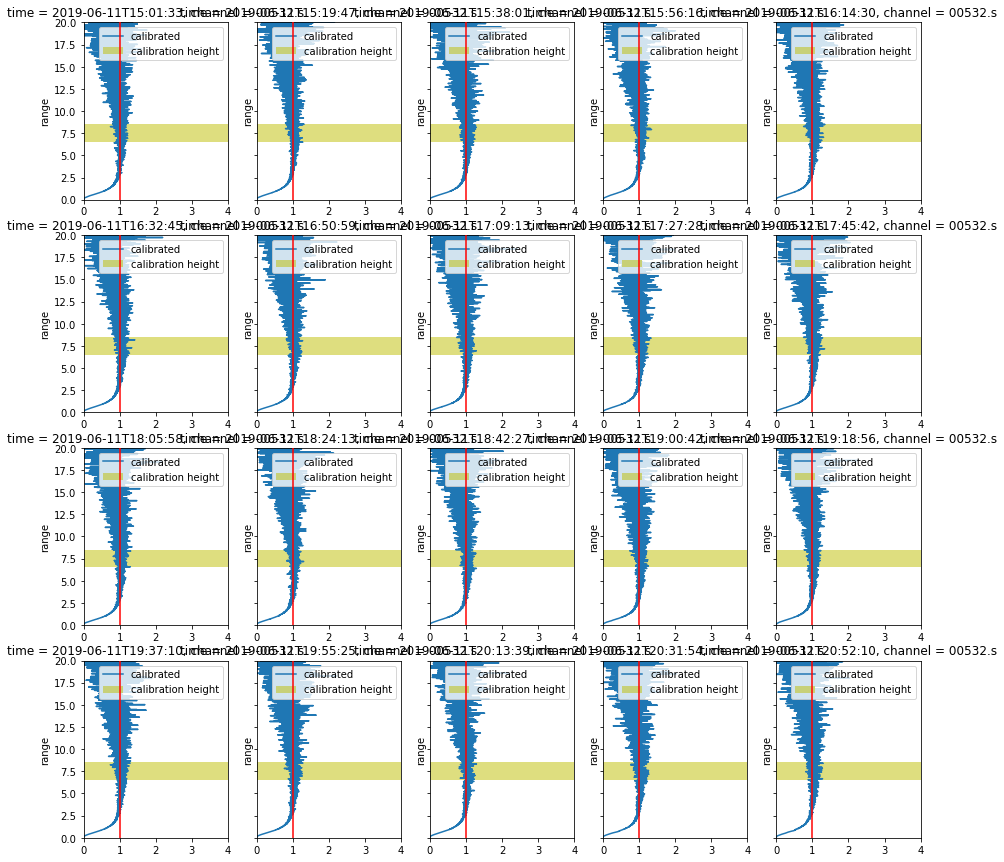

In [21]:
N = np.int_(np.linspace(0, len(new['time'])-1, 20))
f, axs = plt.subplots(ncols=5, nrows=4, figsize=[15,15], sharey=True)
for n, ax in enumerate(axs.flatten()):
    (new.isel(time=N[n], channel=1)['calibrated']/new.isel(time=N[n], channel=1)['simulated']).plot(y='range', label='calibrated', ax=ax)
#     new1.isel(time=N[n], channel=1)['simulated'].plot(y='range', linestyle = '--', label='simulated', ax=ax)
# new1.isel(time=N[n], channel=1)['calibrated'].plot(y='range', label='calibrated s', ax=ax)
# new1.isel(time=N[n], channel=1)['simulated'].plot(y='range', linestyle = '--', label='simulated s', ax=ax)
    ax.axhspan(8.5, 6.5, color='y', alpha=0.5, lw=0, label='calibration height')
    ax.axvline(1, color='r', zorder=10)
    ax.legend()
    ax.set_ylim(0,20)
    ax.set_xlim(0, 4)


### DISTRIBUTION DES SR

In [2]:
listfiles = sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/').glob('*RF_v1.nc'))

loaded = xr.open_dataset(listfiles[0])
limite = np.where((loaded['range']*1e3+2160>loaded.attrs['calibration height'][0])&
                  (loaded['range']*1e3+2160<20000))[0]
atb532 = xr.open_dataset(listfiles[0]).isel(channel=0, range=limite)['calibrated']
sr532 = loaded.isel(channel=0, range=limite)['calibrated']/loaded.isel(channel=0, range=limite)['simulated']

for file in listfiles[1:]:
    loaded = xr.open_dataset(file)
    print(file)
    atb532 = xr.concat([atb532, loaded.isel(channel=0, range=limite)['calibrated']], dim='time')
    sr532 = xr.concat([sr532, loaded.isel(channel=0, range=limite)['calibrated']/loaded.isel(channel=0, range=limite)['simulated']], dim='time')

/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-14RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-15RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-16RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-17RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-21RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-22RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-24RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-29RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-01-31RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-04RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-05RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-08RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-11RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-19RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-02-25RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/2019-03-04R

In [3]:
atb532mean = atb532.resample(time='15min').mean()
atb532mean_reshape = np.mean(np.reshape(np.array(atb532mean), (atb532mean.shape[0], int(atb532mean.shape[1]/2), 2)), axis=2)
# np.round(np.array(atb532mean['range']).reshape(-1, 2).mean(axis=1), 2)
sr532mean = sr532.resample(time='15min').mean()
sr532mean_reshape = np.mean(np.reshape(np.array(sr532mean), (sr532mean.shape[0], int(sr532mean.shape[1]/2), 2)), axis=2)

atb532mean.shape, atb532mean_reshape.shape

((31976, 2000), (31976, 1000))

In [61]:
listfiles = sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/').glob('*RF_v1.nc'))

loaded = xr.open_dataset(listfiles[0])
limite = np.where((loaded['range']*1e3+2160>loaded.attrs['calibration height'][0])&
                 (loaded['range']*1e3+2160<20000))[0]
atb355 = xr.open_dataset(listfiles[0]).isel(channel=1, range=limite)['calibrated']
sr355 = loaded.isel(channel=1, range=limite)['calibrated']/loaded.isel(channel=1, range=limite)['simulated']

for file in listfiles[1:]:
    loaded = xr.open_dataset(file)
    print(file)
    atb355 = xr.concat([atb355, loaded.isel(channel=1, range=limite)['calibrated']], dim='time')
    sr355 = xr.concat([sr355, loaded.isel(channel=1, range=limite)['calibrated']/loaded.isel(channel=1, range=limite)['simulated']], dim='time')

/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-14RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-15RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-16RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-17RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-21RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-22RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-24RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-28RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-29RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-30RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-01-31RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-04RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-05RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-11RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/2019-02-19RF_v1.nc
/homedata/nmpnguyen/OPAR/Processed/RF/LI

KeyboardInterrupt: 

In [5]:
atb355mean = atb355.resample(time='15min').mean()
sr355mean = sr355.resample(time='15min').mean()
# atb355mean_reshape = np.mean(np.reshape(np.array(atb355mean[:,:]), (atb355mean.shape[0], int(atb355mean.shape[1]/2), 2)), axis=2)
# sr355mean_reshape = np.mean(np.reshape(np.array(sr355mean[:,:]), (sr355mean.shape[0], int(atb355mean.shape[1]/2), 2)), axis=2)

sr355mean.shape#, sr355mean_reshape.shape

(24787, 947)

In [195]:
xy, xids, yids = np.intersect1d(np.round(np.array(atb532mean['range']).reshape(-1, 2).mean(axis=1), 2), 
              np.round(np.array(atb355mean['range']),2),
              return_indices = True)
time_xy, time_xids, time_yids = np.intersect1d(atb532mean['time'].values, atb355mean['time'].values,
                                              return_indices=True)

X532 = atb532mean_reshape[:, xids]
X532 = X532[time_xids,:]

Y355 = np.array(atb355mean)[:, yids]
Y355 = Y355[time_yids,:]

X532.shape, Y355.shape

((436, 709), (436, 709))

In [193]:
ids = np.intersect1d(np.where(~np.isnan(X532.ravel()))[0], np.where(~np.isnan(Y355.ravel()))[0])
                     
H = np.histogram2d(X532.ravel()[ids], Y355.ravel()[ids], bins=100,
                  range = [[0, 1e-5], [0, 1e-5]])
Hprobas = H[0]/len(X532.ravel())*100
Xxedges, Yyedges = np.meshgrid(H[1], H[2])

[Text(0.5, 0, 'ATB532'), Text(0, 0.5, 'ATB355'), Text(0.5, 1.0, 'OPAR')]

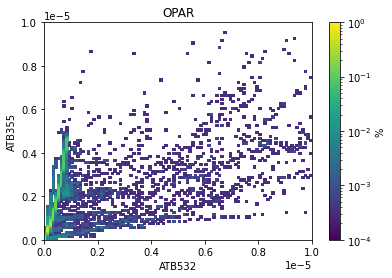

In [194]:
from matplotlib.colors import LogNorm

ff, ax = plt.subplots()
p = ax.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmin=1e-4, vmax=1e0)) #
c = plt.colorbar(p, ax=ax, label='%')
ax.set(xlabel='ATB532', ylabel='ATB355', title='OPAR')
# ax.set(xlim = (0, 1e-5), ylim = (0, 1e-5))

In [6]:
### Distribution des SR

xy, xids, yids = np.intersect1d(np.round(np.array(sr532mean['range']).reshape(-1, 2).mean(axis=1), 2), 
              np.round(np.array(sr355mean['range']),2),
              return_indices = True)
time_xy, time_xids, time_yids = np.intersect1d(sr532mean['time'].values, sr355mean['time'].values,
                                              return_indices=True)

X532 = sr532mean_reshape[:, xids]
X532 = X532[time_xids,:]

Y355 = np.array(sr355mean)[:, yids]
Y355 = Y355[time_yids,:]

ids = np.intersect1d(np.where(~np.isnan(X532.ravel()))[0], np.where(~np.isnan(Y355.ravel()))[0])
                     

In [9]:
H = np.histogram2d(X532.ravel()[ids], Y355.ravel()[ids], bins=100,
                  range = [[0, 100], [0, 100]])
Hprobas = H[0]/len(X532.ravel())*100
Xxedges, Yyedges = np.meshgrid(H[1], H[2])

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
from matplotlib.colors import LogNorm

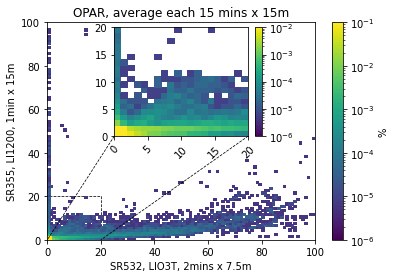

In [45]:

ff, ax = plt.subplots()
p = ax.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-1, vmin=1e-6)) #
c = plt.colorbar(p, ax=ax, label='%')
ax.set(xlabel='SR532, LIO3T, 2mins x 7.5m', ylabel='SR355, LI1200, 1min x 15m', 
       title='OPAR, average each 15 mins x 15m')
# ax.set(xlim=(0,30), ylim=(0,30))
axins = inset_axes(ax, width="50%", height="50%", loc='upper center')
pins = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-02, vmin=1e-6))
plt.setp(axins.get_xticklabels(), rotation=45)
axins.set_ylim(0, 20)
axins.set_xlim(0, 20)
# cins = plt.colorbar(pins, ax=axins, label='%')
# colorbar
cax = inset_axes(axins,
                 width="5%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05, 0., 1, 1),
                 bbox_transform=axins.transAxes,
                 borderpad=0,
                 )
ff.colorbar(pins, cax=cax)
pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, 
                        edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)


[Text(0.5, 0, 'SR532'), Text(0, 0.5, 'SR355')]

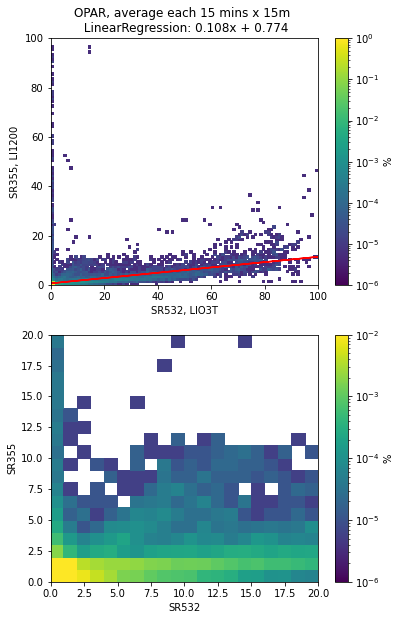

In [58]:
# from sklearn.linear_model import LinearRegression
# modeleReg=LinearRegression()
# modeleReg.fit(X532.ravel()[ids].reshape(1, -1), Y355.ravel()[ids].reshape(1, -1))
# modeleReg.score(X532.ravel()[ids].reshape(1, -1), Y355.ravel()[ids].reshape(-1, 1))
# RMSE=np.sqrt(((Y355.ravel()[ids].reshape(-1, 1)-modeleReg.predict(X532.ravel()[ids].reshape(-1, 1)))**2).sum()/len(Y355.ravel()[ids].reshape(-1, 1)))

# f, ax = plt.subplots()
# ax.plot(Y355.ravel()[ids].reshape(1, -1), modeleReg.predict(X532.ravel()[ids].reshape(-1, 1)))
# ax.set_xlim(0,100)

from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(X532.ravel()[ids], Y355.ravel()[ids])
fitLine = slope * X532.ravel()[ids] + intercept


ff, (ax, axins) = plt.subplots(figsize=[6,10], nrows=2)
p = ax.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e0, vmin=1e-6)) #
c = plt.colorbar(p, ax=ax, label='%')
ax.set(xlabel='SR532, LIO3T', ylabel='SR355, LI1200', 
       title=f'OPAR, average each 15 mins x 15m \n LinearRegression: {round(slope,3)}x + {round(intercept,3)}')
ax.plot(X532.ravel()[ids], fitLine, c='r')
ax.set_xlim(0,100)
ax.set_ylim(0,100)

p = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-02, vmin=1e-6))
cins = plt.colorbar(pins, ax=axins, label='%')
axins.set_ylim(0, 20)
axins.set_xlim(0, 20)
axins.set(xlabel='SR532', ylabel='SR355')
# axins = inset_axes(ax, width="50%", height="50%", loc='upper center')
# pins = axins.pcolormesh(Xxedges, Yyedges, Hprobas.T, norm = LogNorm(vmax=1e-02, vmin=1e-6))
# plt.setp(axins.get_xticklabels(), rotation=45)
# axins.plot(X532.ravel()[ids], fitLine, c='r')
# axins.set_ylim(0, 20)
# axins.set_xlim(0, 20)
# # cins = plt.colorbar(pins, ax=axins, label='%')
# # colorbar
# cax = inset_axes(axins,
#                  width="5%",  # width = 10% of parent_bbox width
#                  height="100%",  # height : 50%
#                  loc='lower left',
#                  bbox_to_anchor=(1.05, 0., 1, 1),
#                  bbox_transform=axins.transAxes,
#                  borderpad=0,
#                  )
# ff.colorbar(pins, cax=cax)
# pp, p1, p2 = mark_inset(ax, axins, loc1=3, loc2=4, fill=False, 
#                         edgecolor="k", linestyle="--", zorder=0, linewidth=0.75)


In [27]:
X532.ravel()[ids].reshape(1, -1)

array([[0.98778018, 0.99749903, 0.98689293, ..., 0.26575808, 0.79401834,
        0.79765489]])

In [53]:
print(len(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LI1200/').glob('*RF_v1.nc'))),
len(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/').glob('*RF_v1.nc'))))
nb_profils = 0
for file in listfiles:
    loaded = xr.open_dataset(file)
    nb_profils = nb_profils + len(loaded['time'])

nb_profils

55 62


12440

In [54]:
len(X532.ravel()[ids])

443125

In [57]:
atb532mean_reshape

array([[ 8.80512028e-07,  8.81630516e-07,  8.83038602e-07, ...,
         1.33486682e-07,  1.49121946e-07,  1.39883479e-07],
       [ 8.81534741e-07,  8.82457519e-07,  8.82618135e-07, ...,
         1.54032787e-07,  1.40754514e-07,  1.44039216e-07],
       [ 8.85864875e-07,  8.87098710e-07,  8.80163436e-07, ...,
         1.47132727e-07,  1.34669796e-07,  1.46098008e-07],
       ...,
       [ 7.02633645e-08,  3.72539301e-08,  5.22015069e-08, ...,
        -1.04126908e-07,  1.85732199e-07,  1.35738807e-07],
       [ 3.65095640e-08,  3.52897820e-08,  3.61818860e-08, ...,
        -1.22907820e-08,  1.14400597e-07,  4.01807136e-09],
       [ 9.86924338e-09,  7.80499887e-09,  8.15834438e-09, ...,
        -3.91413898e-08, -5.20846827e-09, -2.14271550e-08]])

In [60]:
xr.open_dataset(sorted(Path('/homedata/nmpnguyen/OPAR/Processed/RF/LIO3T/').glob('*RF_v1.nc'))[0])

<xarray.Dataset>
Dimensions:     (channel: 2, range: 16380, time: 202)
Coordinates:
  * time        (time) datetime64[ns] 2019-01-11T17:08:16 ... 2019-01-11T23:5...
  * range       (range) float64 0.0 0.0075 0.015 0.0225 ... 122.8 122.8 122.8
  * channel     (channel) object '00532.p' '00532.s'
Data variables:
    calibrated  (channel, time, range) float64 ...
    simulated   (channel, time, range) float64 ...
Attributes:
    calibration height:  [5000 7000]